<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Multivariate_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [88]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse}, MAPE: {mape}"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [48]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'])

In [49]:
train = train[~(train.date < '2020-03-01')]
test = test[~(test.date < '2020-03-01')]

In [50]:
from prophet.make_holidays import make_holidays_df

def create_holidays_df(country_code, year_list):
    holidays_df = make_holidays_df(year_list=year_list, country=country_code)
    holidays_df['country_code'] = country_code
    return holidays_df

# List of countries
countries = ['US', 'LU', 'IE', 'NO', 'CH', 'SG', 'IS', 'DK', 'AU']

# Years for which to generate holidays
years = [2020 + i for i in range(3)]

# Generate holidays for each country and concatenate
holidays = pd.concat([create_holidays_df(country, years) for country in countries])


In [51]:
holidays['holiday'] = 1
holidays

,ds,holiday,country_code
0,2020-01-20,1,US
1,2020-02-17,1,US
2,2020-10-12,1,US
3,2020-01-01,1,US
4,2020-05-25,1,US
...,...,...,...
23,2022-01-03,1,AU
24,2022-04-15,1,AU
25,2022-04-18,1,AU
26,2022-12-25,1,AU


In [52]:
train_with_holiday = train.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
train_with_holiday['holiday'].fillna(0, inplace = True)
test_with_holiday = test.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
test_with_holiday['holiday'].fillna(0, inplace = True)

In [53]:
# drop useless columns
train_dropped = train_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'new_confirmed_std1'])
test_dropped = test_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'new_confirmed_std1'])

In [57]:
pd.set_option('display.max_columns', None)

In [61]:
# Features that are constant for each country
for col in train_dropped.loc[:, train_dropped.nunique() <= 10].columns:
  print(col)

country_code
aggregation_level
gdp_usd
gdp_per_capita_usd
AG.LND.AGRI.K2
AG.LND.AGRI.ZS
AG.LND.ARBL.HA
AG.LND.ARBL.HA.PC
AG.LND.ARBL.ZS
AG.LND.CROP.ZS
AG.LND.FRST.K2
AG.LND.FRST.ZS
AG.LND.TOTL.K2
AG.PRD.CROP.XD
AG.PRD.FOOD.XD
AG.PRD.LVSK.XD
AG.SRF.TOTL.K2
BX.KLT.DINV.CD.WD
EG.ELC.ACCS.RU.ZS
EG.ELC.ACCS.UR.ZS
EG.ELC.ACCS.ZS
EG.ELC.RNEW.ZS
EG.FEC.RNEW.ZS
EN.ATM.CO2E.GF.KT
EN.ATM.CO2E.GF.ZS
EN.ATM.CO2E.KT
EN.ATM.CO2E.LF.KT
EN.ATM.CO2E.LF.ZS
EN.ATM.CO2E.PC
EN.ATM.CO2E.SF.KT
EN.ATM.CO2E.SF.ZS
EN.ATM.PM25.MC.M3
EN.ATM.PM25.MC.T1.ZS
EN.ATM.PM25.MC.T2.ZS
EN.ATM.PM25.MC.T3.ZS
EN.ATM.PM25.MC.ZS
EN.BIR.THRD.NO
EN.FSH.THRD.NO
EN.HPT.THRD.NO
EN.MAM.THRD.NO
EN.POP.DNST
ER.FSH.CAPT.MT
ER.FSH.PROD.MT
ER.LND.PTLD.ZS
ER.PTD.TOTL.ZS
IP.JRN.ARTC.SC
IT.CEL.SETS
IT.CEL.SETS.P2
IT.MLT.MAIN
IT.MLT.MAIN.P2
IT.NET.BBND
IT.NET.BBND.P2
IT.NET.SECR
IT.NET.SECR.P6
IT.NET.USER.ZS
NV.IND.TOTL.CN
NV.IND.TOTL.ZS
NY.ADJ.AEDU.GN.ZS
NY.ADJ.DCO2.CD
NY.ADJ.DCO2.GN.ZS
NY.ADJ.DKAP.CD
NY.ADJ.DMIN.CD
NY.ADJ.DMIN.GN.ZS
NY.ADJ.DN

In [60]:
train_dropped.columns.tolist()

['date',
 'location_key_x',
 'country_code',
 'new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'latitude',
 'longitude',
 'area_sq_km',
 'life_expectancy',
 'mobility_workplaces',
 'aggregation_level',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'gdp_usd',
 'gdp_per_capita_usd',
 'AG.LND.AGRI.K2',
 'AG.LND.AGRI.ZS',
 'AG.LND.ARBL.HA',
 'AG.LND.ARBL.HA.PC',
 'AG.LND.ARBL.ZS',
 'AG.LND.CROP.ZS',
 'AG.LND.FRST.K2',
 'AG.LND.FRST.ZS',
 'AG.LND.TOTL.K2',
 'AG.PRD.CROP.XD',
 'AG.PRD.FOOD.XD',
 'AG.PRD.LVSK.XD',
 'AG.SRF.TOTL.K2',
 'BX.KLT.DINV.CD.WD',
 'EG.ELC.ACCS.RU.ZS',
 'EG.ELC.ACCS.UR.ZS',
 'EG.ELC.ACCS.ZS',
 'EG.ELC.RNEW.ZS',
 'EG.FEC.RNEW.ZS',
 'EN.ATM.CO2E.GF.KT',
 'EN.ATM.CO2E.GF.ZS',
 'EN.ATM.CO2E.KT',
 'EN.ATM.CO2E.LF.KT',
 'EN.ATM.CO2E.LF.ZS',
 'EN.ATM.CO2E.PC',
 'EN.ATM.CO2E.SF.KT',
 'EN.ATM.CO2E.SF.ZS',
 'EN.ATM.PM25.MC.M3',
 'EN.ATM.PM25.MC.T1.ZS',
 'EN.ATM.PM25.MC.T2.ZS',
 'EN.ATM.PM25.MC.T3.ZS',
 

In [66]:
train_prepared = train_dropped[[
 'date',
 'country_code',
 'new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'area_sq_km',
 'life_expectancy',
 'mobility_workplaces',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'new_confirmed',
 'new_confirmed_lag1',
 'new_confirmed_lag3',
 'new_confirmed_lag7',
 'new_confirmed_mean3',
 'new_confirmed_mean7',
 'new_confirmed_std3',
 'new_confirmed_std7',
 'new_confirmed_max3',
 'new_confirmed_max7',
 'new_confirmed_min3',
 'new_confirmed_min7',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season',
 'holiday']]

test_prepared = test_dropped[[
 'date',
 'country_code',
 'new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'area_sq_km',
 'life_expectancy',
 'mobility_workplaces',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'new_confirmed',
 'new_confirmed_lag1',
 'new_confirmed_lag3',
 'new_confirmed_lag7',
 'new_confirmed_mean3',
 'new_confirmed_mean7',
 'new_confirmed_std3',
 'new_confirmed_std7',
 'new_confirmed_max3',
 'new_confirmed_max7',
 'new_confirmed_min3',
 'new_confirmed_min7',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season',
 'holiday']]

In [69]:
# label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# season
train_prepared['season'] = label_encoder.fit_transform(train_multi_prophet['season'])
test_prepared['season']= label_encoder.transform(test_multi_prophet['season'])

<ipython-input-69-2254f2398099>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prepared['season'] = label_encoder.fit_transform(train_multi_prophet['season'])
<ipython-input-69-2254f2398099>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prepared['season']= label_encoder.transform(test_multi_prophet['season'])


In [70]:
columns_to_sum = ['new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'area_sq_km',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'new_confirmed',
 'new_confirmed_lag1',
 'new_confirmed_lag3',
 'new_confirmed_lag7',
 'new_confirmed_mean3',
 'new_confirmed_mean7',
 'new_confirmed_std3',
 'new_confirmed_std7',
 'new_confirmed_max3',
 'new_confirmed_max7',
 'new_confirmed_min3',
 'new_confirmed_min7',]
columns_to_average = ['life_expectancy',
 'mobility_workplaces',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season',
 'holiday']

# Define your aggregation dictionary
aggregation_dict = {col: 'sum' for col in columns_to_sum}
aggregation_dict.update({col: 'mean' for col in columns_to_average})

# Perform the groupby and aggregation
train_country_agg = train_prepared.groupby(['country_code', 'date']).agg(aggregation_dict)
train_country_agg.reset_index(inplace=True)

test_country_agg = test_prepared.groupby(['country_code', 'date']).agg(aggregation_dict)
test_country_agg.reset_index(inplace=True)

In [71]:
test_country_agg

,country_code,date,new_deceased,cumulative_deceased,population,population_male,population_female,area_sq_km,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,life_expectancy,mobility_workplaces,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,AU,2022-01-01,0.0,16.0,4668756.0,2013026.0,2022565.0,4859125.0,0.0,3342385.0,2155.0,2152.0,1486.0,656.0,1904.333333,1408.285714,434.243123,574.088482,2167.0,2167.0,1404.0,782.0,82.400000,-39.333333,5.0,1.0,1.0,2022.0,1.0,1.0,52.0,2.0,1.0
1,AU,2022-01-02,2.0,18.0,4668756.0,2013026.0,2022565.0,4859125.0,0.0,3342385.0,2405.0,2155.0,1406.0,794.0,2237.333333,1638.428571,146.178425,610.289814,2405.0,2405.0,2140.0,846.0,82.400000,-12.333333,6.0,1.0,1.0,2022.0,2.0,2.0,52.0,2.0,0.0
2,AU,2022-01-03,0.0,18.0,4668756.0,2013026.0,2022565.0,4859125.0,8125.0,3350510.0,2634.0,2405.0,2152.0,856.0,2398.000000,1892.428571,252.772258,599.883720,2659.0,2659.0,2155.0,1006.0,82.400000,-68.000000,0.0,1.0,1.0,2022.0,3.0,3.0,1.0,2.0,1.0
3,AU,2022-01-04,0.0,18.0,4668756.0,2013026.0,2022565.0,4859125.0,2658.0,3353168.0,3326.0,2634.0,2155.0,1009.0,2788.333333,2223.428571,504.073926,670.627172,3351.0,3351.0,2380.0,1389.0,82.400000,-28.333333,1.0,1.0,1.0,2022.0,4.0,4.0,1.0,2.0,0.0
4,AU,2022-01-05,0.0,18.0,4668756.0,2013026.0,2022565.0,4859125.0,11919.0,3365087.0,3608.0,3326.0,2405.0,1486.0,3189.333333,2526.571429,505.102209,755.835002,3608.0,3609.0,2634.0,1404.0,82.400000,-26.333333,2.0,1.0,1.0,2022.0,5.0,5.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,US,2022-09-11,19.0,1048386.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,11464.0,3227.0,88425.0,5892.0,29525.333333,66525.428571,42409.091056,108804.577436,77073.0,288985.0,2195.0,1332.0,78.357261,-8.279762,6.0,3.0,9.0,2022.0,254.0,11.0,36.0,0.0,0.0
2566,US,2022-09-12,569.0,1048955.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,87513.0,11464.0,73885.0,18537.0,34068.000000,76379.142857,53005.995621,109436.028934,94990.0,288275.0,2195.0,2195.0,78.357261,-21.017857,0.0,3.0,9.0,2022.0,255.0,12.0,37.0,0.0,0.0
2567,US,2022-09-13,522.0,1049477.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,61642.0,87513.0,3227.0,125989.0,53539.666667,67186.714286,64817.239842,98579.773844,123744.0,258535.0,3572.0,2195.0,78.357261,-46.553571,1.0,3.0,9.0,2022.0,256.0,13.0,37.0,0.0,0.0
2568,US,2022-09-14,978.0,1050455.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,115724.0,61642.0,11464.0,144151.0,88293.000000,63125.714286,88089.546596,92771.546426,183376.0,248284.0,24560.0,2195.0,78.357261,-46.571429,2.0,3.0,9.0,2022.0,257.0,14.0,37.0,0.0,0.0


In [72]:
# put zeros to missing lagging features
train_country_agg.fillna(0, inplace = True)
test_country_agg.fillna(0, inplace = True)

In [73]:
# Use US as a representative
US_train = train_country_agg.loc[train_country_agg.country_code == 'US']
US_test = test_country_agg.loc[test_country_agg.country_code == 'US']

In [74]:
US_train.head()

,country_code,date,new_deceased,cumulative_deceased,population,population_male,population_female,area_sq_km,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,life_expectancy,mobility_workplaces,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
5934,US,2020-03-01,3.0,9.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,0.0,17.0,12.0,4.0,1.0,12.333333,10.571429,9.410703,13.268793,23.0,38.0,6.0,1.0,78.357261,2.077381,6.0,1.0,3.0,2020.0,61.0,1.0,9.0,1.0,0.0
5935,US,2020-03-02,4.0,13.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,0.0,47.0,17.0,8.0,9.0,25.333333,16.000000,22.735566,20.891035,49.0,60.0,7.0,3.0,78.357261,1.916667,0.0,1.0,3.0,2020.0,62.0,2.0,10.0,1.0,0.0
5936,US,2020-03-03,3.0,16.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,0.0,56.0,47.0,12.0,5.0,40.000000,23.285714,26.039400,28.041259,65.0,75.0,16.0,3.0,78.357261,0.898810,1.0,1.0,3.0,2020.0,63.0,3.0,10.0,1.0,0.0
5937,US,2020-03-04,3.0,19.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,0.0,75.0,56.0,17.0,19.0,59.333333,31.285714,32.619262,36.363342,92.0,95.0,33.0,4.0,78.357261,1.148810,2.0,1.0,3.0,2020.0,64.0,4.0,10.0,1.0,0.0
5938,US,2020-03-05,5.0,24.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,0.0,75.0,75.0,47.0,4.0,68.666667,41.428571,31.308007,40.864109,103.0,107.0,44.0,5.0,78.357261,1.166667,3.0,1.0,3.0,2020.0,65.0,5.0,10.0,1.0,0.0


In [75]:
US_train.drop(columns = 'country_code', inplace = True)
US_test.drop(columns = 'country_code', inplace = True)

<ipython-input-75-bc2790471334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_train.drop(columns = 'country_code', inplace = True)
<ipython-input-75-bc2790471334>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_test.drop(columns = 'country_code', inplace = True)


In [78]:
US_train.reset_index(drop=True)
US_test.reset_index(drop=True)

,date,new_deceased,cumulative_deceased,population,population_male,population_female,area_sq_km,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_confirmed,new_confirmed_lag1,new_confirmed_lag3,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,life_expectancy,mobility_workplaces,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,2022-01-01,273.0,824764.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,204491318.0,161960.0,446844.0,489474.0,58404.0,398222.333333,398642.000000,271697.549252,305421.257838,623898.0,821873.0,139361.0,49565.0,78.357261,-42.035714,5.0,1.0,1.0,2022.0,1.0,1.0,52.0,3.0,1.0
1,2022-01-02,233.0,824997.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,204491318.0,286868.0,161960.0,585863.0,189805.0,298557.333333,412508.142857,227329.747071,311153.251501,530913.0,861103.0,117025.0,55882.0,78.357261,-18.107143,6.0,1.0,1.0,2022.0,2.0,2.0,52.0,3.0,0.0
2,2022-01-03,1650.0,826647.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,204491318.0,1018686.0,286868.0,446844.0,535815.0,489171.333333,481489.714286,571945.042861,434189.788505,1125370.0,1274572.0,111404.0,83547.0,78.357261,-34.714286,0.0,1.0,1.0,2022.0,3.0,3.0,1.0,3.0,0.0
3,2022-01-04,2364.0,829011.0,335073176.0,170796496.0,177855320.0,9840963.0,715255.0,205206573.0,884796.0,1018686.0,161960.0,380733.0,730116.666667,553498.714286,725069.140357,514012.016969,1535749.0,1560685.0,193851.0,96513.0,78.357261,-27.636905,1.0,1.0,1.0,2022.0,4.0,4.0,1.0,3.0,0.0
4,2022-01-05,2129.0,831140.0,335073176.0,170796496.0,177855320.0,9840963.0,211372.0,205417945.0,707134.0,884796.0,286868.0,489474.0,870205.333333,584593.000000,580995.719170,520437.824733,1504314.0,1571483.0,407404.0,97628.0,78.357261,-26.976190,2.0,1.0,1.0,2022.0,5.0,5.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,2022-09-11,19.0,1048386.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,11464.0,3227.0,88425.0,5892.0,29525.333333,66525.428571,42409.091056,108804.577436,77073.0,288985.0,2195.0,1332.0,78.357261,-8.279762,6.0,3.0,9.0,2022.0,254.0,11.0,36.0,0.0,0.0
254,2022-09-12,569.0,1048955.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,87513.0,11464.0,73885.0,18537.0,34068.000000,76379.142857,53005.995621,109436.028934,94990.0,288275.0,2195.0,2195.0,78.357261,-21.017857,0.0,3.0,9.0,2022.0,255.0,12.0,37.0,0.0,0.0
255,2022-09-13,522.0,1049477.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,61642.0,87513.0,3227.0,125989.0,53539.666667,67186.714286,64817.239842,98579.773844,123744.0,258535.0,3572.0,2195.0,78.357261,-46.553571,1.0,3.0,9.0,2022.0,256.0,13.0,37.0,0.0,0.0
256,2022-09-14,978.0,1050455.0,335073176.0,170796496.0,177855320.0,9840963.0,0.0,223755029.0,115724.0,61642.0,11464.0,144151.0,88293.000000,63125.714286,88089.546596,92771.546426,183376.0,248284.0,24560.0,2195.0,78.357261,-46.571429,2.0,3.0,9.0,2022.0,257.0,14.0,37.0,0.0,0.0


In [79]:
model_us = prophet.Prophet()
for col in US_train.columns:
    if col not in ['date', 'new_confirmed']:
        model_us.add_regressor(col)
model_us=model_us.fit(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp133b2zom/6a84ta16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp133b2zom/uq6brsto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52808', 'data', 'file=/tmp/tmp133b2zom/6a84ta16.json', 'init=/tmp/tmp133b2zom/uq6brsto.json', 'output', 'file=/tmp/tmp133b2zom/prophet_model92covkq7/prophet_model-20231209062833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:28:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:28:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [80]:
train_pred_US=model_us.predict(US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred_US.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,area_sq_km,area_sq_km_lower,area_sq_km_upper,cumulative_deceased,cumulative_deceased_lower,cumulative_deceased_upper,cumulative_persons_fully_vaccinated,cumulative_persons_fully_vaccinated_lower,cumulative_persons_fully_vaccinated_upper,day_of_week,day_of_week_lower,day_of_week_upper,dayofmonth,dayofmonth_lower,dayofmonth_upper,dayofyear,dayofyear_lower,dayofyear_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holiday,holiday_lower,holiday_upper,life_expectancy,life_expectancy_lower,life_expectancy_upper,mobility_workplaces,mobility_workplaces_lower,mobility_workplaces_upper,month,month_lower,month_upper,new_confirmed_lag1,new_confirmed_lag1_lower,new_confirmed_lag1_upper,new_confirmed_lag3,new_confirmed_lag3_lower,new_confirmed_lag3_upper,new_confirmed_lag7,new_confirmed_lag7_lower,new_confirmed_lag7_upper,new_confirmed_max3,new_confirmed_max3_lower,new_confirmed_max3_upper,new_confirmed_max7,new_confirmed_max7_lower,new_confirmed_max7_upper,new_confirmed_mean3,new_confirmed_mean3_lower,new_confirmed_mean3_upper,new_confirmed_mean7,new_confirmed_mean7_lower,new_confirmed_mean7_upper,new_confirmed_min3,new_confirmed_min3_lower,new_confirmed_min3_upper,new_confirmed_min7,new_confirmed_min7_lower,new_confirmed_min7_upper,new_confirmed_std3,new_confirmed_std3_lower,new_confirmed_std3_upper,new_confirmed_std7,new_confirmed_std7_lower,new_confirmed_std7_upper,new_deceased,new_deceased_lower,new_deceased_upper,new_persons_fully_vaccinated,new_persons_fully_vaccinated_lower,new_persons_fully_vaccinated_upper,population,population_lower,population_upper,population_female,population_female_lower,population_female_upper,population_male,population_male_lower,population_male_upper,quarter,quarter_lower,quarter_upper,season,season_lower,season_upper,weekly,weekly_lower,weekly_upper,weekofyear,weekofyear_lower,weekofyear_upper,year,year_lower,year_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,-74496.581491,-28754.346358,6478.612533,-74496.581491,-74496.581491,62854.373664,62854.373664,62854.373664,-284.560056,-284.560056,-284.560056,27926.764042,27926.764042,27926.764042,-5643.784793,-5643.784793,-5643.784793,-4568.177098,-4568.177098,-4568.177098,-50501.899035,-50501.899035,-50501.899035,511136.842831,511136.842831,511136.842831,69103.863140,69103.863140,69103.863140,0.0,0.0,0.0,1.095461,1.095461,1.095461,6650.574754,6650.574754,6650.574754,-397450.949147,-397450.949147,-397450.949147,16583.511086,16583.511086,16583.511086,-16787.506123,-16787.506123,-16787.506123,-23498.395092,-23498.395092,-23498.395092,-140523.982446,-140523.982446,-140523.982446,83533.575095,83533.575095,83533.575095,69445.931303,69445.931303,69445.931303,42330.826220,42330.826220,42330.826220,-47109.320091,-47109.320091,-47109.320091,-10944.886708,-10944.886708,-10944.886708,2926.811095,2926.811095,2926.811095,-57053.199115,-57053.199115,-57053.199115,-8710.986168,-8710.986168,-8710.986168,-294.095462,-294.095462,-294.095462,-935.03338,-935.03338,-935.03338,12213.364427,12213.364427,12213.364427,-10572.667778,-10572.667778,-10572.667778,-4399.720114,-4399.720114,-4399.720114,-538.031015,-538.031015,-538.031015,-6249.489476,-6249.489476,-6249.489476,-7785.651009,-7785.651009,-7785.651009,83957.411456,83957.411456,83957.411456,0.0,0.0,0.0,-11642.207827
2020-03-02,-74001.987202,-13109.445405,21605.574935,-74001.987202,-74001.987202,77582.424685,77582.424685,77582.424685,-284.560056,-284.560056,-284.560056,27926.478963,27926.478963,27926.478963,-5643.784793,-5643.784793,-5643.784793,4559.108756,4559.108756,4559.108756,-47080.029475,-47080.029475,-47080.029475,507375.969740,507375.969740,507375.969740,78277.265657,78277.265657,78277.265657,0.0,0.0,0.0,1.09546

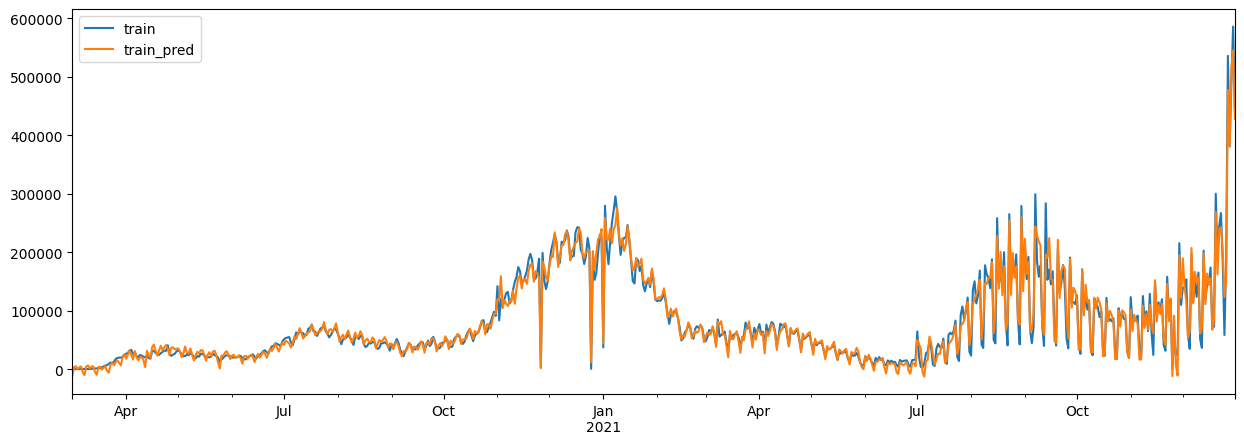

In [84]:
US_train.set_index('date', inplace = True)
pd.concat([US_train['new_confirmed'],train_pred_US['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

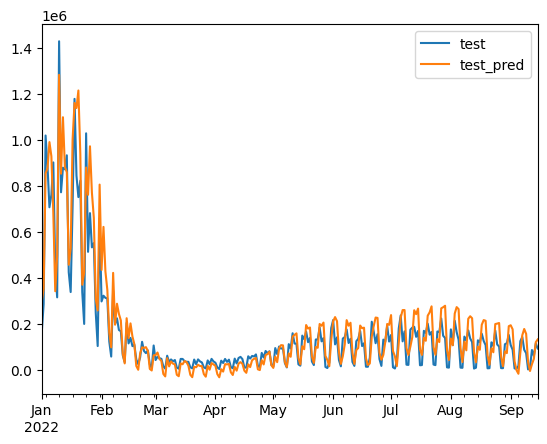

In [87]:
test_pred_US=model_us.predict(US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
US_test.set_index('date', inplace = True)
pd.concat([US_test['new_confirmed'],test_pred_US['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [89]:
# training data
model_performance(US_train.new_confirmed, train_pred_US.yhat)

'RMSE: 13978.21962978159, MAPE: 223.68869778021286'

In [90]:
# testing data
model_performance(US_test.new_confirmed, test_pred_US.yhat)

'RMSE: 82497.56215342994, MAPE: 94.23076331518506'

In [93]:
# Now fit a model for each country
train_pred = train_country_agg.copy()
train_pred = train_pred[['date','country_code','new_confirmed']]
train_pred = train_pred.set_index('date')
train_pred.new_confirmed = None
train_pred.columns = ['country_code','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])

test_pred = test_country_agg.copy()
test_pred.new_confirmed = None
test_pred = test_pred[['date','country_code','new_confirmed']]
test_pred = test_pred.set_index('date')
test_pred.columns = ['country_code','predicted_new_confirmed']
test_pred.reset_index(inplace = True)

In [94]:
loc_list = list(train_pred.country_code.unique())

for loc in loc_list:
  # initialize the dataset
  train_interest = train_country_agg.loc[train_country_agg.country_code == loc] # select the rows in the training data
  test_interest = test_country_agg.loc[test_country_agg.country_code == loc] # select the rows in the testing data
  # drop country_code
  train_interest.drop(columns = 'country_code', inplace = True)
  test_interest.drop(columns = 'country_code', inplace = True)
  # fit the model on the train dataset
  model = prophet.Prophet()
  for col in train_interest.columns:
    if col not in ['date', 'new_confirmed']:
      model.add_regressor(col)
  model=model.fit(train_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  # predict the training data
  # fit the model on the train dataset
  pred_for_train = model.predict(train_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  for date in pred_for_train.ds:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.ds == date, 'yhat'])
  # predict test dataset
  pred_for_test = model.predict(test_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  for date in pred_for_test.ds:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.ds == date, 'yhat'])

<ipython-input-94-b11f188cc996>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_interest.drop(columns = 'country_code', inplace = True)
<ipython-input-94-b11f188cc996>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_interest.drop(columns = 'country_code', inplace = True)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp133b2zom/w7ixofdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp133b2zom/jpteh1zn.json
DEBUG:cmdstan

In [98]:
print("the rmse on the training data is ", mean_squared_error(train_country_agg.new_confirmed, train_pred.predicted_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test_country_agg.new_confirmed, test_pred.predicted_new_confirmed, squared = False))

the rmse on the training data is  4781.664635508857
the rmse on the testing data is  26254.1588122951
